# The Most Common Terraform Security Issues in 1000 GitHub Open Source Projects

This Jupyter notebook is the accompanying resource to the cloudlines.de blog article [The Most Common Terraform Security Issues in 1000 GitHub Open Source Projects](https://cloudlines.de/posts/the-most-common-terraform-security-issues-in-1000-github-open-source-projects/). Read the blog article for more details and interpretation of the results.

# Prerequesites

* install [tfsec](https://github.com/aquasecurity/tfsec) to scan the Terraform code
* you need to create a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token) in order to access the GitHub API
* you will need the following python libraries installed
    * pandas
    * requests
    * pygit2

In [71]:
import pandas as pd
import sqlite3
import requests as r
import time
import pygit2
import glob
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

from matplotlib import style
plt.style.use("ggplot")

In [1]:
# paste your GitHub Personal Access Token here, as described in the 'Prerequesites' section
gh_token = "<pase_your_token_here>"

In [4]:
base_url = "https://api.github.com/search/repositories?q=language:terraform&sort=stars"
attributes = ['id', 'name', 'clone_url', 'default_branch', 'stargazers_count', 'size']
repos_per_page = 100


result = r.get(base_url, params={'page': 1, 'per_page': 1})
num_repos = result.json()['total_count']
md(f"GitHub hosts **{num_repos}** Terraform repositories. Unfortunately, due to API restrictions we can only download the top **1000** of these.")

GitHub hosts **175592** Terraform repositories. Unfortunately, due to API restrictions we can only download the top **1000** of these.

# Request Data from GitHub API

First we will use the `/search/repositories` endpoint of the GitHub API to request the top 1000 Terraform repositories. The top 1000 repositories are defined by their `stargazers_count`, i.e. the number of stars a repository has. 

A SQLite database `github_terraform_repos.sql` stores the results.

In [4]:
def extract_data(items):
    data = []
    for item in items:
        date = {}
        for attr in attributes:
            date[attr] = item[attr]
        data.append(date)

    return pd.DataFrame(data)


def get_page_items(num, repos_per_page):
    result = r.get(base_url, params={
        'page': num, 
        'per_page': repos_per_page,
    }, headers={
        'Authorization': f"token {gh_token}"
    })
    if result.status_code != 200:
        print(result.status_code)
        print(result.json())
    return result.json()['items']
    

def safe_data(df, file="github_terraform_repos.sql", table="github_repos"):
    con = sqlite3.connect(file)
    df.to_sql(table, con, if_exists="append")
    con.close()

    
start_time = time.time()
total_items = 0

for i in range(1, int(1000 / repos_per_page) + 1):
    items = get_page_items(i, repos_per_page)
    df = extract_data(items)
    safe_data(df)
    total_items += len(items)
    
    print(f"{time.time() - start_time:.1f}s\ti={i} fetched={len(items)}\ttotal={total_items}")    

3.3s	i=1 fetched=100	total=100
6.5s	i=2 fetched=100	total=200
9.7s	i=3 fetched=100	total=300
12.9s	i=4 fetched=100	total=400
16.0s	i=5 fetched=100	total=500
19.7s	i=6 fetched=100	total=600
22.7s	i=7 fetched=100	total=700
25.4s	i=8 fetched=100	total=800
28.8s	i=9 fetched=100	total=900
31.7s	i=10 fetched=100	total=1000


# Clone GitHub Repositories

Next we will clone the main brach (e.g. `main` or `master`) of all the 1000 repositories to our local file storage for further analysis. The repositories will be stored in the
subfolder `./repositories`.

**Notes**: 
* This will take quite some time. Also, some repositories are quite large. This can easily take 1 - 2 hours.
* The cloning operation does not have a retry logic implemented. Due to network issues, it might be necessary to run the below cell multiple times in order to clone all repositories. 

In [5]:
start_time = time.time()
working_dir = os.getcwd()
file = "github_terraform_repos.sql"
table = "github_repos"

con = sqlite3.connect(file)
cur = con.cursor()

for i, row in enumerate(cur.execute(f"SELECT id, name, clone_url, default_branch FROM {table}")):
    _id, name, clone_url, branch = row
    print(f"{time.time() - start_time:.1f}s\ti={i} Cloning branch '{branch}' of repository '{name}'")
    
    folder = f"{working_dir}/repositories/{_id}_{name}"
    if not os.path.exists(folder):
        pygit2.clone_repository(
            clone_url,
            folder,
            checkout_branch=branch
        )  
    
con.close()

0.0s	i=0 Cloning branch 'master' of repository 'terraform-aws-eks'
0.0s	i=1 Cloning branch 'master' of repository 'terraform-aws-vpc'
0.0s	i=2 Cloning branch 'main' of repository 'ampernetacle'
0.0s	i=3 Cloning branch 'master' of repository 'stack'
0.0s	i=4 Cloning branch 'master' of repository 'terraform-up-and-running-code'
0.0s	i=5 Cloning branch 'main' of repository 'typhoon'
0.0s	i=6 Cloning branch 'master' of repository 'best-practices'
0.0s	i=7 Cloning branch 'master' of repository 'terraform-best-practices'
0.0s	i=8 Cloning branch 'master' of repository 'terraform-best-practices'
0.0s	i=9 Cloning branch 'master' of repository 'terraform-course'
0.0s	i=10 Cloning branch 'master' of repository 'okd'
0.0s	i=11 Cloning branch 'master' of repository 'terraform-guides'
0.0s	i=12 Cloning branch 'main' of repository 'boilerplates'
0.0s	i=13 Cloning branch 'main' of repository 'terraform-aws-eks-blueprints'
0.0s	i=14 Cloning branch 'master' of repository 'terraform-beginner-to-advanced-

In [30]:
# get the top 10 repositories by number of stars
con = sqlite3.connect("github_terraform_repos.sql")
df = pd.read_sql_query("SELECT * FROM github_repos", con)
df.head(n=10)

,index,id,name,clone_url,default_branch,stargazers_count,size
0,0,136401408,terraform-aws-eks,https://github.com/terraform-aws-modules/terra...,master,2952,1817
1,1,101660954,terraform-aws-vpc,https://github.com/terraform-aws-modules/terra...,master,2354,913
2,2,448329962,ampernetacle,https://github.com/jpetazzo/ampernetacle.git,main,2336,11
3,3,61223609,stack,https://github.com/segmentio/stack.git,master,2081,342
4,4,73706797,terraform-up-and-running-code,https://github.com/brikis98/terraform-up-and-r...,master,1987,257
5,5,99544448,typhoon,https://github.com/poseidon/typhoon.git,main,1695,7764
6,6,45932086,best-practices,https://github.com/hashicorp/best-practices.git,master,1486,399
7,7,94737529,terraform-best-practices,https://github.com/ozbillwang/terraform-best-p...,master,1419,123
8,8,106203762,terraform-best-practices,https://github.com/antonbabenko/terraform-best...,master,1401,1027
9,9,70161585,terraform-course,https://github.com/wardviaene/terraform-course...,master,1340,188


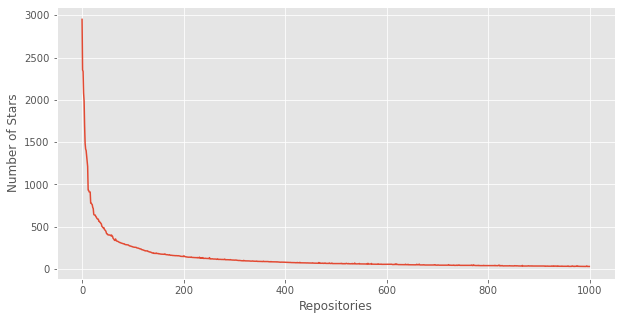

In [265]:
# plot the distribution of number of stars
# Distribution of Star Counts
con = sqlite3.connect("github_terraform_repos.sql")
df = pd.read_sql_query("SELECT * FROM github_repos", con)
plt.figure(figsize=(10, 5))
plt.plot(df["stargazers_count"])
plt.xlabel("Repositories")
plt.ylabel("Number of Stars")
plt.savefig("01-distribution-of-star-counts.png")

# Run tfsec to Generate CSV Reports

Now that we downloaded the Terraform code to the `repositories` folder, we can run **tfsec** to find potential security issues. **tfsec** will generate a CSV report for each repository.

To make things easier we will use the following bash script. Copy the code to a file called `run_tfsec.sh`.


#### run_tfsec.sh
```bash 
#!/bin/bash

cd ./repositories

for repo in $(ls .); do
    if [ -d "$repo" ]; then
        tfsec $repo --ignore-hcl-errors --soft-fail --format csv --out "$repo.csv" --no-module-downloads
    fi
done
```

Then add permissions to execute the file and then run the script. This took ~5 minutes on my laptop.


```bash
$ chmod +x run_tfsec.sh
$ ./run_tfsec.sh
```

# Save CSV Reports in SQLite

After generating the tfsec CSV reports, we will now:
1. read all CSV reports
2. concatenate the reports to one big pandas dataframe
3. store the result in a new SQLite database for future processing

In [80]:
temp_df

,file,start_line,end_line,rule_id,severity,description,link,passed,repository
0,main.tf,262,290,google-compute-enable-shielded-vm-im,MEDIUM,Instance does not have shielded VM integrity m...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
1,main.tf,262,290,google-compute-enable-shielded-vm-vtpm,MEDIUM,Instance does not have VTPM for shielded VMs e...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
2,main.tf,262,290,google-compute-no-default-service-account,CRITICAL,Instance uses the default service account.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
3,main.tf,262,290,google-compute-no-project-wide-ssh-keys,MEDIUM,Instance allows use of project-level SSH keys.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
4,main.tf,303,303,google-compute-no-public-ingress,CRITICAL,Firewall rule allows ingress traffic from mult...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
5,main.tf,303,303,google-compute-no-public-ingress,CRITICAL,Firewall rule allows ingress traffic from mult...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
6,main.tf,287,288,google-compute-no-public-ip,HIGH,Instance has a public IP allocated.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
7,main.tf,271,275,google-compute-vm-disk-encryption-customer-key,LOW,Instance disk encryption does not use a custom...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello
8,main.tf,132,149,google-storage-enable-ubla,MEDIUM,Bucket has uniform bucket level access disabled.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,hello


In [90]:
working_dir = os.getcwd()
csv_files = glob.glob(f"{working_dir}/repositories/*.csv")

print(f"Found {len(csv_files)} CSV files.")

df_list = []
for filename in csv_files:
    # repository_name = filename.split("_", maxsplit=1)[1][:-4]
    repository_name = filename.split("/")[-1][:-4]
    temp_df = pd.read_csv(filename, index_col=None, header=0)
    temp_df['repository'] = repository_name
    df_list.append(temp_df)

df = pd.concat(df_list, axis=0, ignore_index=True)
with sqlite3.connect("github_terraform_repos.sql"):
    df.to_sql("findings", con, if_exists="replace")

df.head()

Found 999 CSV files.


,file,start_line,end_line,rule_id,severity,description,link,passed,repository
0,consul.tf,60,77,aws-ec2-enable-at-rest-encryption,HIGH,Root block device is not encrypted.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,85101662_consul-ec2-auto-join-example
1,consul.tf,41,58,aws-ec2-enable-at-rest-encryption,HIGH,Root block device is not encrypted.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,85101662_consul-ec2-auto-join-example
2,consul.tf,60,77,aws-ec2-enforce-http-token-imds,HIGH,Instance does not require IMDS access to requi...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,85101662_consul-ec2-auto-join-example
3,consul.tf,41,58,aws-ec2-enforce-http-token-imds,HIGH,Instance does not require IMDS access to requi...,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,85101662_consul-ec2-auto-join-example
4,main.tf,49,89,aws-ec2-enable-at-rest-encryption,HIGH,Root block device is not encrypted.,https://aquasecurity.github.io/tfsec/v1.18.0/c...,False,92152743_tf_aws_openvpn


# Analysis

In [267]:
con = sqlite3.connect("github_terraform_repos.sql")
df = pd.read_sql_query("SELECT * FROM findings", con)
df.severity = pd.Categorical(df.severity, ["CRITICAL", "HIGH", "MEDIUM", "LOW"])

num_unique_repo = len(df.repository.unique())
num_findings = len(df)
findings_per_repo = num_findings / num_unique_repo
print(f"Number of scanned repositories: {num_unique_repo}. Number of findings: {num_findings} ({findings_per_repo:.0f} per repo)")

Number of scanned repositories: 647. Number of findings: 28492 (44 per repo)


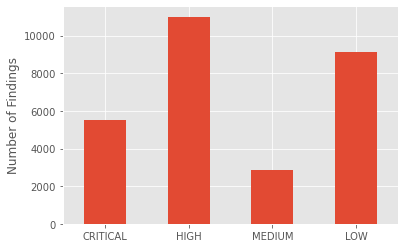

In [268]:
# Number of Findings by Severity
ax = df.severity.value_counts().sort_index().plot(kind='bar', ylabel="Number of Findings", rot=0)
ax.figure.savefig("02-number-of-findings-by-severity.png")

In [269]:
x = df.value_counts(subset=["repository","severity"]).to_frame().reset_index().pivot_table(index=["repository"], columns=['severity'], fill_value=0)
x = x.droplevel(level=0, axis=1)
x["Total"] = x.CRITICAL + x.HIGH + x.MEDIUM + x.LOW
x = x.sort_values(["Total"], ascending=False).head(n=15)
print(x.to_markdown())

| repository                                   |   CRITICAL |   HIGH |   MEDIUM |   LOW |   Total |
|:---------------------------------------------|-----------:|-------:|---------:|------:|--------:|
| 374766273_tree-sitter-hcl                    |        200 |    856 |       50 |  1798 |    2904 |
| 233153882_fortigate-terraform-deploy         |        376 |    260 |       66 |   265 |     967 |
| 167387704_terraform                          |        190 |    330 |      156 |   221 |     897 |
| 58405565_cg-provision                        |        113 |    292 |       85 |   359 |     849 |
| 244703180_hashicorp                          |        221 |    310 |        0 |    94 |     625 |
| 496268752_terraform-on-aws-eks               |         99 |    308 |       89 |     4 |     500 |
| 170957588_CyberRange                         |         28 |    308 |        8 |   128 |     472 |
| 342887356_mtc-terraform                      |        134 |     88 |       12 |   233 |     467 |


<ipython-input-270-2e6bcfdfa59d>:9: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set(ylabel="Number of Findings", xlabel="Rule", xticks=[])


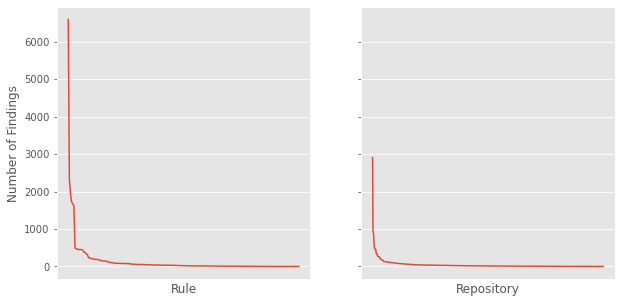

In [270]:
# Number of Findings by Rule and Repository 
num_findings_by_rule = df.rule_id.value_counts()
num_findings_per_repo = df.value_counts(subset=["repository"]).values

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))


ax1.plot(num_findings_by_rule)
ax1.set(ylabel="Number of Findings", xlabel="Rule", xticks=[])

ax2.plot(num_findings_per_repo)
ax2.set(xlabel="Repository", xticks=[])
plt.savefig("03-num-findings-by-rule-and-repo.png")